# Training Notebook

Use this notebook if you want to train your own GPT model based on your own custom dataset.

## Imports & Device Setup

In [1]:
import os
import torch
import torch.nn as nn
import tiktoken
import matplotlib.pyplot as plt

# Importing from local modules
from model import GPTModel
from dataset import split_train_val_test, create_dataloader
from generate import generate_and_print
from train_utils import calc_loss_batch, evaluate_model, plot_losses, calc_loss_loader, print_model_params

# Setup Device (MPS for Mac, CUDA for Windows/Linux, else CPU)
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")
torch.manual_seed(123)

Using device: mps


## Configuration & Hyperparameters

In [2]:
# Model Configuration
GPT_CONFIG_124M = {
    "vocab_size": 50257,    
    "context_length": 256, 
    "emb_dim": 768,         
    "n_heads": 12,          
    "n_layers": 12,         
    "drop_rate": 0.1,       
    "qkv_bias": False       
}

# Training Settings
SETTINGS = {
    "learning_rate": 5e-4,
    "num_epochs": 10,
    "batch_size": 2,
    "weight_decay": 0.1,
    "eval_freq": 10,      # How often to evaluate (steps)
    "eval_iter": 1,       # How many batches to use for evaluation
    "start_context": "Jack Gisburn"  # Text prompt for generation check
}

## Data Loading

### Dataset Information
For demonstration purposes, the code below uses **The Verdict** ([Source Link](https://en.wikisource.org/wiki/The_Verdict)).

> **Important Context:**
> When using this small demo file, the model will likely overfit. **This result isn't a failure;** it is the **expected outcome** of pretraining a large model on such a small text file.

However, the pipeline is designed to be easily adaptable to your own custom data.

---

### How to Use Your Own Data
Follow these steps to train on a custom dataset:

1. **Prepare your file**
   Rename your custom text file to `input.txt`.

2. **Upload it**
   Place `input.txt` inside the `./data/wikitext-2/` folder.
   * *Optional:* You may also change the `DATA_DIR` variable in the "Data Loading" cell to point to a different custom folder.

3. **Run the notebook**
   The "Data Loading" cell includes an **Auto-Split** feature:
   * If it finds `input.txt` but **no** split files (e.g., `train.txt`), it will ask if you want to split them automatically.
   * It will then generate the train/validation/test splits for you and proceed with training.

> **Note:** If you already have pre-split files (`train.txt`, `valid.txt`, `test.txt`), simply ensure they are in the target directory. The notebook will detect them and skip the splitting step.

In [3]:
# --- 1. Configuration ---
# Change this directory to where your data lives
DATA_DIR = "./data/" 
# The name of your single raw file (if you haven't split it yet)
RAW_FILE_NAME = "input.txt" 

# Expected paths
train_path = os.path.join(DATA_DIR, "train.txt")
valid_path = os.path.join(DATA_DIR, "valid.txt")
test_path = os.path.join(DATA_DIR, "test.txt")

# --- 2. Check & Split Logic ---
# Check if the split files already exist
if not (os.path.exists(train_path) and os.path.exists(valid_path)):
    print(f"Split files (train.txt/valid.txt) NOT found in {DATA_DIR}")
    
    # Interactive check
    do_split = input(f"Do you want to split '{RAW_FILE_NAME}' now? (y/n): ").lower().strip()
    
    if do_split == 'y':
        raw_path = os.path.join(DATA_DIR, RAW_FILE_NAME)
        try:
            split_train_val_test(raw_path)
            print("Successfully created dataset splits.")
        except FileNotFoundError:
            print(f"Error: Could not find '{RAW_FILE_NAME}' inside '{DATA_DIR}'. Please check the file path.")
            raise
    else:
        raise FileNotFoundError("Training cannot proceed without 'train.txt' and 'valid.txt'.")
else:
    print(f"Found existing split files in {DATA_DIR}. Proceeding...")

# --- 3. Load the Text ---
with open(train_path, "r", encoding="utf-8") as f:
    train_text = f.read()

with open(valid_path, "r", encoding="utf-8") as f:
    val_text = f.read()

print(f"Loaded Train Data: {len(train_text)} characters")
print(f"Loaded Valid Data: {len(val_text)} characters")

# --- 4. Create DataLoaders ---
print("Creating DataLoaders...")
train_loader = create_dataloader(
    train_text,
    batch_size=SETTINGS["batch_size"],
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader(
    val_text,
    batch_size=SETTINGS["batch_size"],
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

print(f"Train Batches: {len(train_loader)}")
print(f"Valid Batches: {len(val_loader)}")

Found existing split files in ./data/. Proceeding...
Loaded Train Data: 17407 characters
Loaded Valid Data: 2047 characters
Creating DataLoaders...
Train Batches: 8
Valid Batches: 1


## Model Initialization

In [4]:
model = GPTModel(GPT_CONFIG_124M)
model.to(device)

optimizer = torch.optim.AdamW(
    model.parameters(), 
    lr=SETTINGS["learning_rate"], 
    weight_decay=SETTINGS["weight_decay"]
)

tokenizer = tiktoken.get_encoding("gpt2")

## Training Loop

This is the main execution block:
1.  We loop through the `num_epochs`.
2.  For each batch, we perform a **Forward Pass** (calculate scaled loss) and a **Backward Pass** (accumulate gradients).
3.  Every `accum_steps`, we perform the **Optimizer Step** (update weights and reset gradients).
4.  Every `eval_freq` *global updates*, we calculate validation loss to check for overfitting.
5.  At the end of every epoch, the model generates a sample text so you can visually see how it is improving.

In [5]:
# --- SETUP GRADIENT ACCUMULATION ---
TARGET_BATCH_SIZE = 4
accum_steps = TARGET_BATCH_SIZE // SETTINGS["batch_size"]

print(f"Physical Batch Size: {SETTINGS['batch_size']}")
print(f"Target Batch Size:   {TARGET_BATCH_SIZE}")
print(f"Accumulation Steps:  {accum_steps}")

print("Starting Training...")

train_losses, val_losses, track_tokens_seen = [], [], []
tokens_seen = 0
global_step = -1

for epoch in range(SETTINGS["num_epochs"]):
    model.train()
    
    # Initialize gradients once before the loop starts
    optimizer.zero_grad() 
    
    for i, (input_batch, target_batch) in enumerate(train_loader):
        # 1. Forward Pass
        loss = calc_loss_batch(input_batch, target_batch, model, device)
        
        # Scale the loss
        # We divide by accum_steps so that the gradients sum up to the correct magnitude
        loss = loss / accum_steps 
        
        # 2. Backward Pass (Accumulates gradients, does NOT update weights yet)
        loss.backward()
        
        # Step only every 'accum_steps' iterations
        if (i + 1) % accum_steps == 0 or (i + 1) == len(train_loader):
            optimizer.step()
            optimizer.zero_grad() # Clear gradients for the next set
            
            # Update global step only when we actually update weights
            global_step += 1

            # Update tokens count (Total tokens processed)
            tokens_seen += input_batch.numel() * accum_steps # Rough estimate correction

            # Periodic Evaluation (Moved inside the update block)
            if global_step % SETTINGS["eval_freq"] == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, SETTINGS["eval_iter"]
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                
                # Multiply loss back by accum_steps just for printing human-readable value
                current_loss_val = loss.item() * accum_steps 
                print(f"Ep {epoch+1} (Iter {i+1}): Train loss {current_loss_val:.3f}, Val loss {val_loss:.3f}")

    # End of Epoch: Generate visual sample
    print(f"\n--- Epoch {epoch+1} Completion Generation ---")
    generate_and_print(model, tokenizer, device, SETTINGS["start_context"])
    print("-------------------------------------------\n")

Physical Batch Size: 2
Target Batch Size:   4
Accumulation Steps:  2
Starting Training...
Ep 1 (Iter 2): Train loss 11.005, Val loss 9.721

--- Epoch 1 Completion Generation ---

[Gen]: Jack Gisburn, the,, the the the,,,,,,, the,,,, the,,,,, the,,, the,, the,,,, the,,, the,, the,,,,,

-------------------------------------------


--- Epoch 2 Completion Generation ---

[Gen]: Jack Gisburn,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

-------------------------------------------

Ep 3 (Iter 6): Train loss 6.303, Val loss 6.710

--- Epoch 3 Completion Generation ---

[Gen]: Jack Gisburn, the, and the the the, and the the, and the. ", and the, and the, and the, and, the, and the the, and the the the, and the, and the, and, and the

-------------------------------------------


--- Epoch 4 Completion Generation ---

[Gen]: Jack Gisburn, and I had been his his of the his his a of the of the of the " was his his his " I had been his my the of the his his he was his he was his his his of t

### Training Results (Plot)

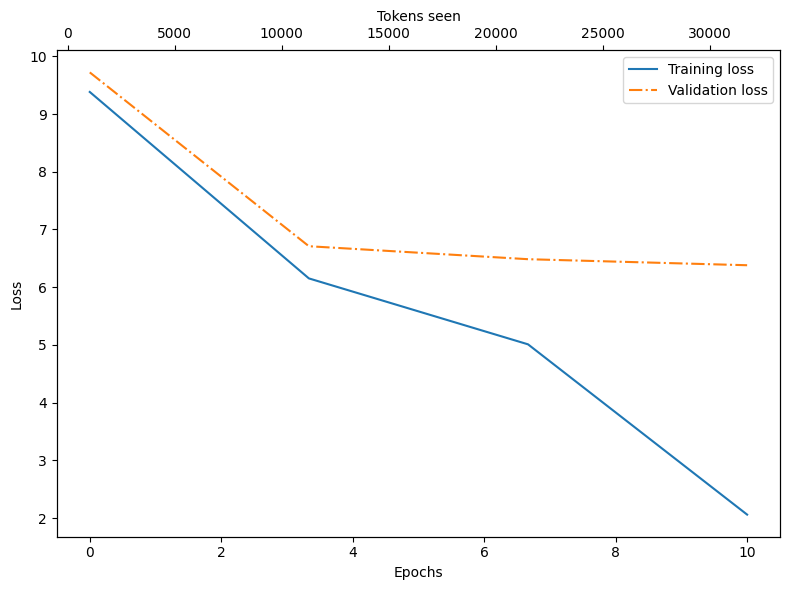

In [6]:
epochs_tensor = torch.linspace(0, SETTINGS["num_epochs"], len(train_losses))
plot_losses(epochs_tensor, track_tokens_seen, train_losses, val_losses)

### Saving Model

In [7]:
save_path = "./model_weights/trained_gpt2.pth"
os.makedirs(os.path.dirname(save_path), exist_ok=True)
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

Model saved to ./model_weights/trained_gpt2.pth


### Model Parameter Count & Weight Tying

**Weight Tying** is a specific technique in language modeling architectures where the **Input Embedding Matrix** and the **Output Linear Layer (Head)** share the exact same weights.

---
#### The 163M vs. 124M Difference
The discrepancy between our custom model (**163M**) and the official GPT-2 Small (**124M**) is exactly the size of the **Output Head**.

* **Official GPT-2 (124M):** Uses Weight Tying. The model reuses the input embedding matrix to predict output tokens.
* **Our Model (163M):** Does not use Weight Tying. It utilizes a distinct, separate linear layer for the output head. So hence our model has an extra **~39 million parameters** because it stores two distinct huge matrices for the vocabulary: one for input, one for output.

---
#### Why Untied Weights?
While tying weights saves memory, it forces one matrix to perform two conflicting roles: representing input meaning and predicting output probabilities. By untying them, we allow the model to learn specialized layers for input and output, thereby increasing capacity and performance.



In [8]:
print_model_params(model)

Total Parameters: 162,419,712
Trainable Parameters: 162,419,712

--- Breakdown ---
Embedding: 38,793,984 (23.9%)
Transformer: 85,028,352 (52.4%)
Head: 38,597,376 (23.8%)


## Test Evaluation

In [9]:
test_path = os.path.join(DATA_DIR, "test.txt")

if not os.path.exists(test_path):
    print(f"SKIPPING TEST: '{test_path}' not found.")
else:
    # 1. Load Test Data
    with open(test_path, "r", encoding="utf-8") as f:
        test_text = f.read()
    
    print(f"Loaded Test Data: {len(test_text)} characters")

    # 2. Create Test Loader
    test_loader = create_dataloader(
        test_text,
        batch_size=SETTINGS["batch_size"],
        max_length=GPT_CONFIG_124M["context_length"],
        stride=GPT_CONFIG_124M["context_length"],
        drop_last=False,
        shuffle=False, 
        num_workers=0
    )
    
    # 3. Calculate Loss
    print("Running final evaluation on test set...")
    model.eval() 

    with torch.no_grad():
        # calc_loss_loader defaults to processing the WHOLE loader if num_batches=None
        test_loss = calc_loss_loader(test_loader, model, device)
            
    print(f"\nTest Loss: {test_loss:.3f}")
    
    # 4. Calculate Perplexity
    # We cast to tensor first to handle cases where test_loss returns a float
    perplexity = torch.exp(torch.tensor(test_loss))
    print(f"Test Perplexity: {perplexity:.3f}")

Loaded Test Data: 1025 characters
Running final evaluation on test set...

Test Loss: 6.286
Test Perplexity: 537.181
